In [1]:
using DifferentialEquations
using LinearAlgebra
using Plots

include("../model/Plant.jl")

Main.Plant

In [10]:
state = Plant.State()
u0 = [state.x, state.y, state.n, state.h, state.Ca, state.V, state.Isyn]

7-element Vector{Float64}:
   0.7
   5.472e-46
   0.137
   0.389
   0.8
 -62.0
   0.0

In [42]:
function countSpikes(sol)
    # Obtain burst reset times.
    resets = []
    for i in 3:length(sol)
        # Detect a local minimum in calcium concentration wherein x variable is increasing.
        if sol[i-1][5] > sol[i-2][5] && sol[i-1][5] > sol[i][5] && sol[i][1] > sol[i-1][1] > sol[i-2][1]
            push!(resets, i)
        end
    end

    #print("$(length(resets)) burst resets observed.")

    V_threshold = 0.0

    # Obtain spike counts per burst.
    spike_counts = []
    for i in 1:length(resets)-1
        spike_count = 0
        for j in resets[i]:resets[i+1]
            if sol[j-1][6] < V_threshold < sol[j][6]
                spike_count += 1
            end
        end
        push!(spike_counts, spike_count)
    end

    if spike_counts == []
        return [0]
    else
        return spike_counts
    end
end

countSpikes (generic function with 1 method)

In [43]:
function transitionMap(spike_counts)
    plt = scatter(1, markeralpha=0.2, legend=false)
    for i in 1:length(spike_counts)-1
        push!(plt, (spike_counts[i], spike_counts[i+1]))
    end
    return plt
end

transitionMap (generic function with 1 method)

In [44]:
function markovChain(spike_counts)
    if length(spike_counts) == 0
        return zeros(0, 0)
    end
    size = max(spike_counts...)
    if size == 0
        return zeros(0, 0)
    end
    rows = []
    for i in 0:size
        row = zeros(size+1)
        for j in 1:length(spike_counts)-1
            if spike_counts[j] == i
                row[spike_counts[j+1]+1] += 1
            end
        end
        if sum(row) == 0
            push!(rows, row)
        else
            push!(rows, row/sum(row))
        end
    end
    return reduce(vcat, transpose.(rows))
end

markovChain (generic function with 1 method)

In [45]:
function melibeNewHelper!(du, u, p, t)
    θ = Plant.Params(
        Cₘ   = p[1],
        gI   = p[2],
        gK   = p[3],
        gₕ   = p[4],
        gL   = p[5],
        gT   = p[6],
        gKCa = p[7],
        EI   = p[8],
        EK   = p[9],
        Eₕ   = p[10],
        EL   = p[11],
        ECa  = p[12],
        Kc   = p[13],
        τₓ   = p[14],
        ρ    = p[15],
        Δx   = p[16],
        ΔCa  = p[17]
    )
    Plant.melibeNew!(du, u, θ, t)
end

melibeNewHelper! (generic function with 1 method)

In [46]:
using Statistics

In [47]:
ΔCa_length = 600
Δx_length = 300

range_ΔCa = range(-150, 50, length=ΔCa_length)
range_Δx = range(-15, 35, length=Δx_length)
params = []
for ΔCa in range_ΔCa
    for Δx in range_Δx
        θ = Plant.Params(
            ΔCa = ΔCa,
            Δx = Δx
        )
        p = [
            θ.Cₘ,
            θ.gI,
            θ.gK,
            θ.gₕ,
            θ.gL,
            θ.gT,
            θ.gKCa,
            θ.EI,
            θ.EK,
            θ.Eₕ,
            θ.EL,
            θ.ECa,
            θ.Kc,
            θ.τₓ,
            θ.ρ,
            θ.Δx,
            θ.ΔCa
        ]
        push!(params, p)
    end
end

tspan = (0, 3e4)

(0, 30000.0)

In [48]:
prob = ODEProblem(melibeNewHelper!, u0, tspan, params[1])
prob_func(prob, i, repeat) = remake(prob, p=params[trunc(Int, i)]) # Why are we getting Floats here?
function output_func(sol, i)
    spike_counts = countSpikes(sol)
    if length(spike_counts) < 2
        return (0, false)
    else
        return (log(var(spike_counts)), false)
    end
end
monteprob = EnsembleProblem(prob, output_func=output_func, prob_func=prob_func, safetycopy=false)
sol = solve(monteprob, Tsit5(), EnsembleThreads(), trajectories=ΔCa_length*Δx_length, verbose=false);

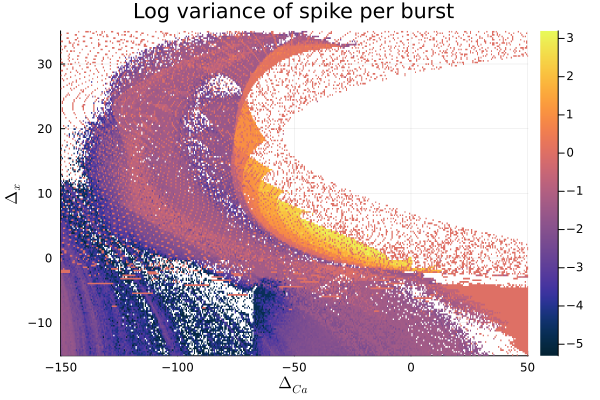

In [ ]:
heatmap(range_ΔCa, range_Δx, reshape(sol, (Δx_length, ΔCa_length)), xlabel="\$Δ_{Ca}\$", ylabel="\$Δ_x\$", color=:thermal, title="Log variance of spike per burst")